# Translation model from COCO -> MPII


In [1]:
import torch
import numpy as np
import torch.nn as nn
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import json

/datagrid/personal/baljibil/repos/env-vitpose/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def describe(data):
  # Find maximum value
  max_val = np.max(data)

  # Find minimum value
  min_val = np.min(data)

  # Find 25th percentile
  percentile_25 = np.percentile(data, 25)

  # Find 75th percentile
  percentile_75 = np.percentile(data, 75)

  print("Maximum:", max_val)
  print("Minimum:", min_val)
  print("25th percentile:", percentile_25)
  print("75th percentile:", percentile_75)

In [3]:


ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/repos/scripts/data/mpii_train_gt.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)

# with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
#     annot_pred_mpii = json.load(f)



In [4]:
X = list()
y = list()
box_scale = list()
box_center = list()
index2orig = list()

print("len: " , len(annot_truth))
for i in range(len(annot_truth)):
  skip = False
  for joint_vis in annot_truth[i]['joints_vis']:
    if joint_vis == 0:
      skip = True
      break
  if skip:
    continue
  index2orig.append(i)
  X.append(annot_pred_coco['annotations'][i]['joints'])
  y.append(annot_truth[i]['joints'])
  box_scale.append(annot_truth[i]['scale'])
  box_center.append(annot_truth[i]['center'])
X = np.array(X)
y = np.array(y)
box_scale = np.array(box_scale)
box_center = np.array(box_center)
print("X shape: ", X.shape)
print("y shape:", y.shape)
print("box scale:", box_scale.shape)
print("box center:", box_center.shape)

len:  22246
X shape:  (14975, 17, 2)
y shape: (14975, 16, 2)
box scale: (14975,)
box center: (14975, 2)


## Normalize the dataset
- First by scale value of the bounding box
- Then either 0-1 normalization

In [120]:
def center_and_scale(data):
    return (data - box_center[:,np.newaxis,:]) / box_scale[:, np.newaxis, np.newaxis]
def uncenter_and_unscale(data):
    return data * box_scale[:, np.newaxis, np.newaxis] + box_center[:,np.newaxis,:]
def standardize(data):
    min_val = -150
    max_val = 150
    return ((data - (min_val)) / (max_val - min_val) - 0.5) * 7.5

def unstandardize(data):
    min_val = -150
    max_val = 150
    return (data / 7.5 + 0.5) * (max_val - min_val) + min_val

def normalize(data):
    data = center_and_scale(data)
    return standardize(data)

def unnormalize(data):
    data = unstandardize(data)
    return uncenter_and_unscale(data)

X_centered = center_and_scale(X)
y_centered = center_and_scale(y)
X_normalized = normalize(X)
y_normalized = normalize(y)



In [121]:
print((X == uncenter_and_unscale(center_and_scale(X))).sum() != 0)
print((X == unnormalize(normalize(X))).sum() != 0)


True
True


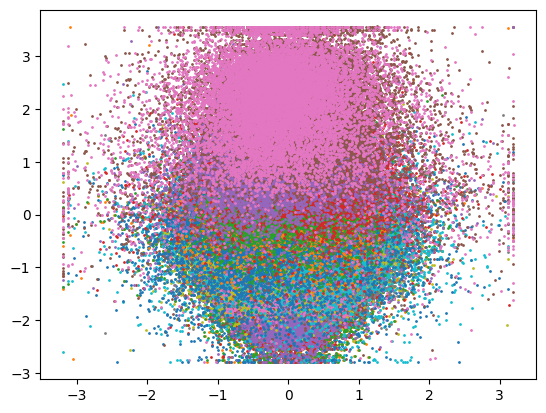

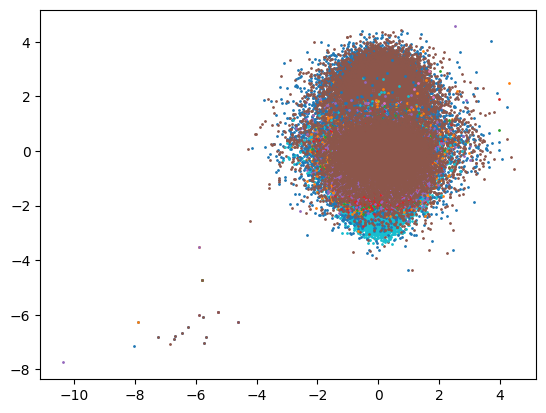

In [9]:
for i in range(17):
  plt.scatter(X_normalized[:, i, 0],X_normalized[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_normalized[:, i, 0],y_normalized[:, i, 1], s=1)
plt.show()

### Display outliers in normalized env

In [10]:
outlier_index = np.argmin(y_normalized)
index = np.unravel_index(outlier_index, y_normalized.shape)
print(index)
print(y[ index[0] ])
print(y_normalized[index[0]])
print("Box center")
print(box_center[index[0]])
print("Box scale")
print(box_scale[index[0]])

print("Joint vis")

print(annot_truth[index2orig[index[0]]]['joints_vis'])
print(len(annot_truth[index2orig[index[0]]]['joints_vis']))


(9630, 14, 0)
[[1241.  533.]
 [1245.  490.]
 [1249.  424.]
 [1276.  420.]
 [1277.  488.]
 [1278.  532.]
 [1263.  422.]
 [1249.  354.]
 [1242.  333.]
 [1229.  297.]
 [1239.  404.]
 [1241.  377.]
 [1223.  365.]
 [1274.  343.]
 [ 736.   15.]
 [1276.  390.]]
[[  0.58581037   3.49316555]
 [  0.67259709   2.56020829]
 [  0.75938381   1.12822738]
 [  1.34519419   1.04144066]
 [  1.36689087   2.51681493]
 [  1.38858755   3.47146887]
 [  1.06313734   1.08483402]
 [  0.75938381  -0.39054025]
 [  0.60750705  -0.84617054]
 [  0.32545021  -1.62725103]
 [  0.54241701   0.69429377]
 [  0.58581037   0.1084834 ]
 [  0.19527012  -0.15187676]
 [  1.30180082  -0.62920373]
 [-10.37101323  -7.74571491]
 [  1.34519419   0.39054025]]
Box center
[1214.  372.]
Box scale
1.15225
Joint vis
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
16


In [11]:
from lovely_numpy import lo

array[14975, 17, 2] n=509150 (3.9Mb) x∈[-3.197, 3.562] μ=-0.087 σ=1.030


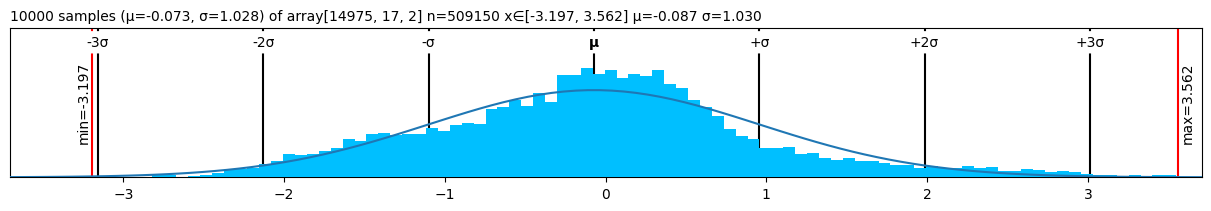

In [12]:
print(lo(X_normalized))
lo(X_normalized).plt

array[14975, 16, 2] n=479200 (3.7Mb) x∈[-10.371, 4.561] μ=-4.574e-05 σ=0.970


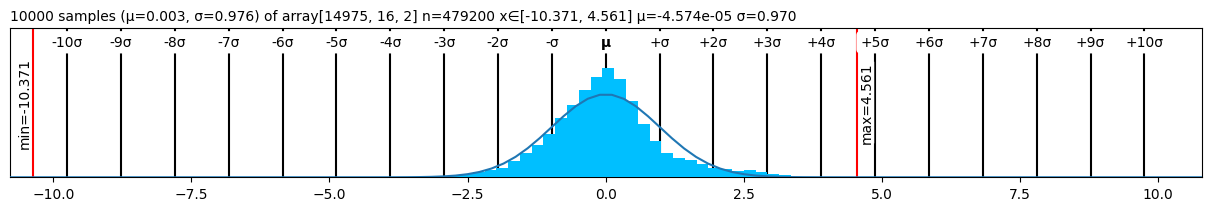

In [13]:
print(lo(y_normalized))
lo(y_normalized).plt

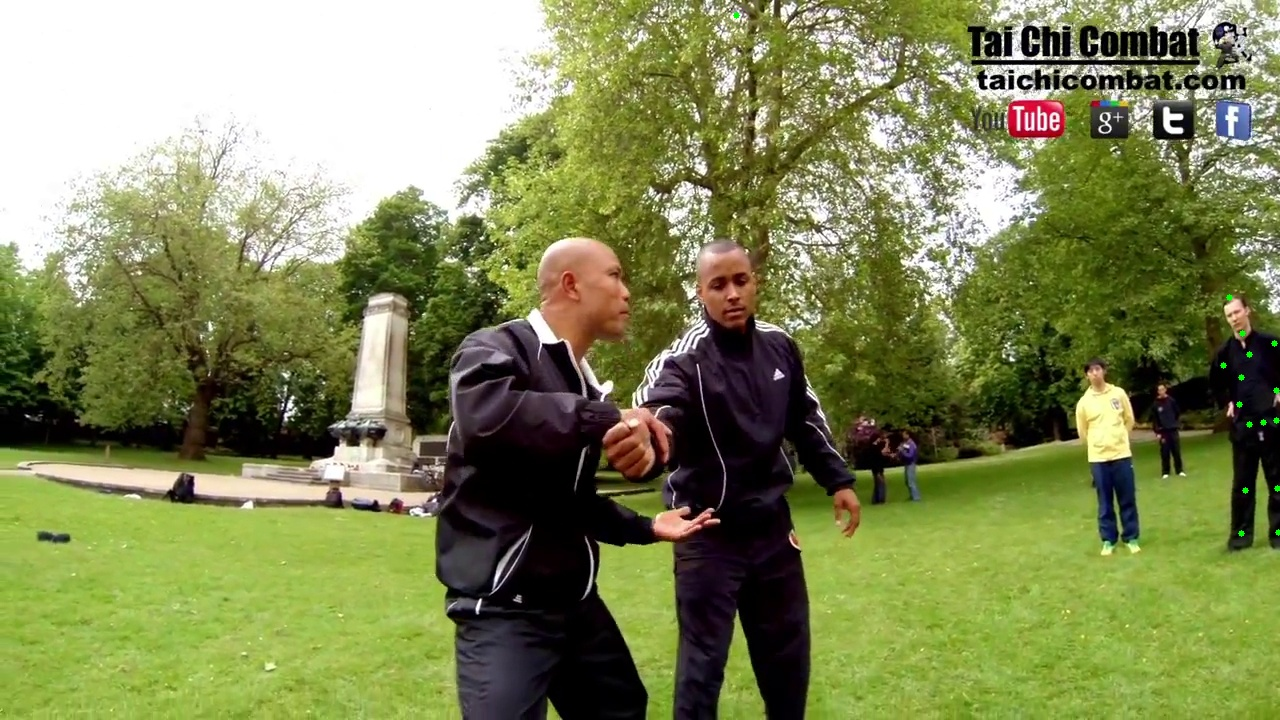

In [14]:
ROOT_FOLDER = "/datagrid/personal/baljibil"

# from utils import display_kp_image
from IPython.display import Image, display
import cv2

def display_kp_image(im_path, keypoints):

  image = cv2.imread(im_path)

  for kp in keypoints:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'tm_results/image_test0.jpg', image)

  display(Image(filename=f'tm_results/image_test0.jpg'))

display_kp_image(ROOT_FOLDER+'/data/MPII_COCO/images/'+annot_truth[index2orig[index[0]]]['image'],
                annot_truth[index2orig[index[0]]]['joints']
                 )

# PCK Accuracy implementation

In [125]:
def printAllPCKh(predict, gt):
    if isinstance(predict, torch.Tensor):
        predict = predict.cpu().numpy()
    if isinstance(gt, torch.Tensor):
        gt = gt.cpu().numpy()
    total_keypoints = gt.shape[0] * gt.shape[1]

    distances = np.linalg.norm((gt - predict), axis=-1)
    head_length = np.linalg.norm((gt[:, 8] - gt[:, 9]), axis=-1) * 0.5 * 0.6

    correct_classified = distances < head_length[:, np.newaxis]
    print(f'Head {(100 * correct_classified[:, 9].sum()) / total_keypoints : .2f}%')
    # correct_classified = np.sum(correct_classified, axis=-1)

    # percentage = correct_classified.sum() / total_keypoints
    # return percentage.item()
# printAllPCKh(y_normalized, y_normalized)

In [60]:
# Given prediction and ground truth with of Nx16x2, where N is sample num return PCKh score.
def calculatePCKh(predict, gt):
    if torch.is_tensor(predict) and torch.is_tensor(gt):
        distances = torch.norm((gt - predict), dim=-1)
        head_length = torch.norm((gt[:, 8] - gt[:, 9]), dim=-1) * 0.5 * 0.6
        correct_classified = distances < head_length[:, None]
        correct_classified = torch.sum(correct_classified, dim=-1)
        total_keypoints = gt.shape[0] * gt.shape[1]
        percentage = correct_classified.sum() / total_keypoints
        return percentage.item()

    else:
        distances = np.linalg.norm((gt - predict), axis=-1)
        head_length = np.linalg.norm((gt[:, 8] - gt[:, 9]), axis=-1) * 0.5 * 0.6
        correct_classified = distances < head_length[:, np.newaxis]
        correct_classified = np.sum(correct_classified, axis=-1)
        total_keypoints = gt.shape[0] * gt.shape[1]
        percentage = correct_classified.sum() / total_keypoints
    return percentage


calculatePCKh(y_normalized, y_normalized)

1.0

In [61]:
uv_error = np.ones((100, 16, 2))
uv_err = np.linalg.norm(uv_error, axis=1)
uv_err.shape

(100, 2)

## Define baseline accuracy

In [62]:
# Fake X identity base/ Direct COCO->MPII
mapping =  {0:16, 1:14, 5: 15, 4: 13, 2:12, 3:11, 15: 9, 14:7, 13: 5, 10:10, 11:8, 12:6}
# Mergeable points merge
X_mpii_identity = np.ones_like(y_centered)
for mpii_key, coco_key in mapping.items():
  X_mpii_identity[:,mpii_key] = X_centered[:,coco_key]
# pelvis (To define baseline, pelvis is almost in the middle of left and right hip)
X_mpii_identity[:,6] = (X_mpii_identity[:,2]+X_mpii_identity[:,3])/2
# thorax (To define baseline, thorax is almost in the middle of left and right shoulder)
X_mpii_identity[:,7] = (X_mpii_identity[:,12]+X_mpii_identity[:,13])/2
X_mpii_identity[:,8] = (X_mpii_identity[:,7]+X_centered[:,0])/2
X_mpii_identity[:,9] = (X_centered[:, 1] + X_centered[:, 2] ) / 2

print(calculatePCKh(X_mpii_identity, y_centered))


0.7943447412353923


## Split train, val, test

In [107]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])
print("Test instance: ", X_test.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

# Create a DataLoader for training and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset)


Train instance:  10182
Val instance:  2546
Test instance:  2247
torch.Size([10182, 17, 2])
torch.Size([10182, 16, 2])
torch.Size([2546, 17, 2])
torch.Size([2546, 16, 2])


In [108]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TranslatorNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.hidden1 = nn.Linear(2*17, 4096)
        self.act1 = nn.Tanh()
        self.hidden2 = nn.Linear(4096, 4096)
        self.act2 = nn.Tanh()
        self.hidden3 = nn.Linear(4096, 2048)
        self.act3 = nn.Tanh()
        self.hidden4 = nn.Linear(2048, 2048)
        self.act4 = nn.Tanh()
        self.hidden5 = nn.Linear(2048, 2048)
        self.act5 = nn.Tanh()
        self.output = nn.Linear(2048, 32)
    def forward(self, x):
        x = self.flatten(x)
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.act5(self.hidden5(x))
        x = self.output(x)
        return x.view(-1, 16, 2)

def init_model():
    return TranslatorNN().to(device)

In [109]:
def train_model(model, lr=0.01, max_epoch=100, logs=[]):
    criterion = nn.L1Loss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    best_epoch = 0
    best_val_loss = 10000000
    best_model = None
    best_accuracy = 0
    # Training loop
    for epoch in range(max_epoch):
        if epoch == 0:
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    outputs = model(inputs)

                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
            val_epoch_loss = val_loss / len(val_dataset)
        
            print(f"Epoch [{epoch}/{max_epoch}], Val Loss: {val_epoch_loss:.6f}")
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_dataset)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_size = 0
        accuracy = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                val_size += inputs.size(0)
                accuracy += (calculatePCKh(outputs, targets))
        val_epoch_loss = val_loss / len(val_dataset)
        # Cuz batch size is 1?
        accuracy = accuracy / (len(val_dataset) / val_loader.batch_size)
        # For 16 keypoints
        if accuracy > best_accuracy:
            best_model = copy.deepcopy(model)
            best_epoch = epoch
            best_val_loss = val_loss
            best_accuracy = accuracy
        logs.append((epoch+1,epoch_loss, val_epoch_loss, accuracy))
        if (epoch+1) % 10 == 1:
            print(f"Epoch [{epoch+1}/{max_epoch}], Train Loss: {epoch_loss:.6f}, Val Loss: {val_epoch_loss:.6f} Accuracy: {accuracy * 100:.2f}%")
    # model at best epoch
    return best_epoch, best_model, best_val_loss, best_accuracy



In [101]:
# learning_rates = [1, 0.1, 0.15, 0.5, 0.01, 0.03, 0.001, 0.003, 0.0001]
learning_rates = [0.01]

# batch_size = [1,4,8,16,32,64]
epoch_max = [200]
param_comb = [{'lr':x, 'epoch':y} for x in learning_rates for y in epoch_max]
print(len(param_comb),param_comb)

best_model = None
best_loss = None
best_params = None
best_accuracy = 0
best_model_logs = []
torch.manual_seed(42)
for param in param_comb:
  print(f'Training for param: {param}')
  lr = param['lr']
  epoch = param['epoch']
  results_logs = []
  model = init_model()
  print(model)
  t_epoch, t_model, t_loss, t_accuracy = train_model(model,lr=lr,max_epoch=epoch,logs=results_logs)
  print(f'{param} -> {t_accuracy:.2f}')

  if t_accuracy > best_accuracy:
    best_model = copy.deepcopy(t_model)
    best_model_logs = copy.deepcopy(results_logs)
    best_loss = t_loss
    best_epoch = t_epoch
    best_params = param
    best_accuracy = t_accuracy
  



1 [{'lr': 0.01, 'epoch': 200}]
Training for param: {'lr': 0.01, 'epoch': 200}


TranslatorNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden1): Linear(in_features=34, out_features=4096, bias=True)
  (act1): Tanh()
  (hidden2): Linear(in_features=4096, out_features=4096, bias=True)
  (act2): Tanh()
  (hidden3): Linear(in_features=4096, out_features=2048, bias=True)
  (act3): Tanh()
  (hidden4): Linear(in_features=2048, out_features=2048, bias=True)
  (act4): Tanh()
  (hidden5): Linear(in_features=2048, out_features=2048, bias=True)
  (act5): Tanh()
  (output): Linear(in_features=2048, out_features=32, bias=True)
)
Epoch [0/200], Val Loss: 0.722130
Epoch [1/200], Train Loss: 0.439287, Val Loss: 0.353049 Accuracy: 20.26%
Epoch [11/200], Train Loss: 0.153570, Val Loss: 0.149647 Accuracy: 69.96%
Epoch [21/200], Train Loss: 0.132550, Val Loss: 0.130040 Accuracy: 77.97%
Epoch [31/200], Train Loss: 0.123511, Val Loss: 0.121030 Accuracy: 81.49%
Epoch [41/200], Train Loss: 0.118427, Val Loss: 0.118229 Accuracy: 83.06%
Epoch [51/200], Train Loss: 0.115567, Val Loss:

In [103]:
print(best_accuracy)

0.8565433040824113


## Eval on test set

In [104]:
best_model.eval()
with torch.no_grad():
  X_test_feed_in = torch.tensor(X_test, dtype=torch.float32).to(device)
  y_test_feed_in = torch.tensor(y_test, dtype=torch.float32).to(device)
  
  prediction = best_model(X_test_feed_in) 
  print(prediction.shape)

  print(f"Accuracy {calculatePCKh(prediction, y_test_feed_in) * 100 : .2f}%")

torch.Size([4493, 16, 2])
Accuracy  85.70%


In [110]:
torch.save(best_model.state_dict(), 'best_translation_model1.pth')

In [112]:
print(best_params)
print(best_epoch)
print(best_accuracy)

{'lr': 0.01, 'epoch': 200}
190
0.8565433040824113


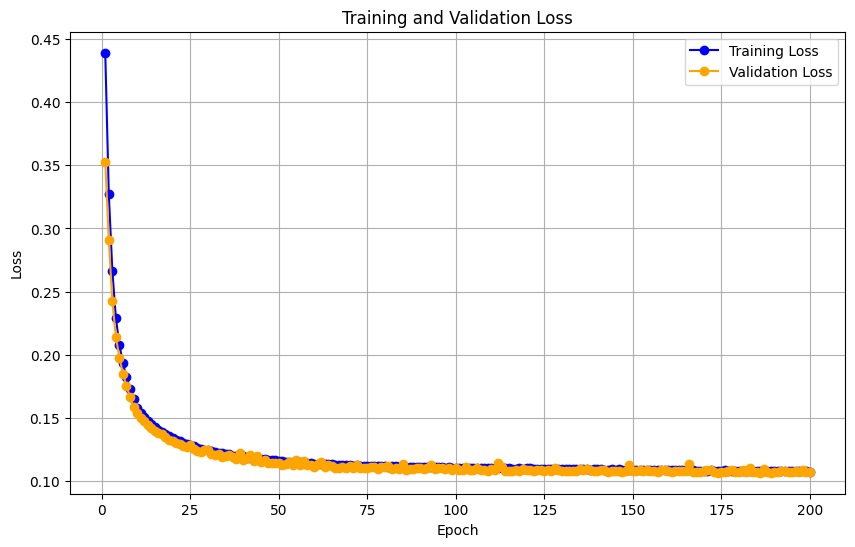

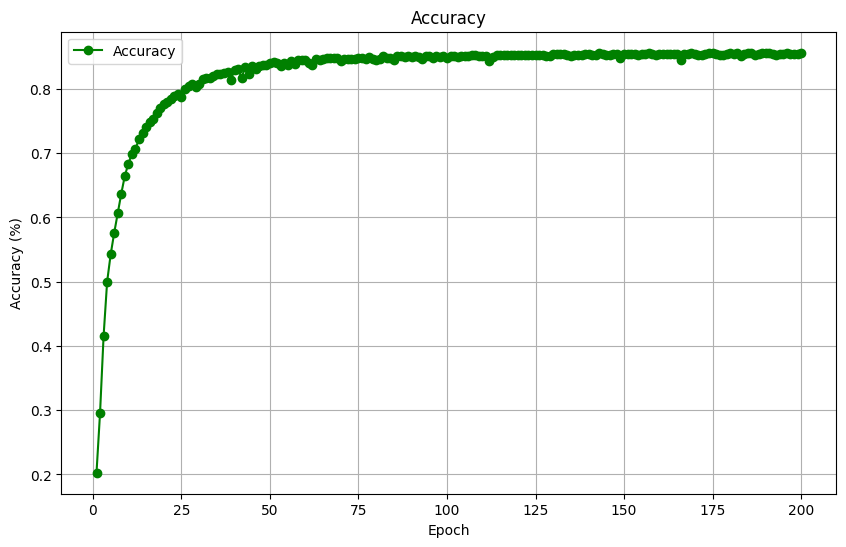

In [114]:
# Training and validation statistics
epochs = [val[0] for val in best_model_logs]
train_losses = [val[1] for val in best_model_logs]
val_losses = [val[2] for val in best_model_logs]
accuracies = [val[3] for val in best_model_logs]

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, label='Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Display some images from translation model

In [116]:
import cv2
from IPython.display import Image, display

In [115]:
dataset_info = dict(
    dataset_name='mpii',
    paper_info=dict(
        author='Mykhaylo Andriluka and Leonid Pishchulin and '
        'Peter Gehler and Schiele, Bernt',
        title='2D Human Pose Estimation: New Benchmark and '
        'State of the Art Analysis',
        container='IEEE Conference on Computer Vision and '
        'Pattern Recognition (CVPR)',
        year='2014',
        homepage='http://human-pose.mpi-inf.mpg.de/',
    ),
    keypoint_info={
        0:
        dict(
            name='right_ankle',
            id=0,
            color=[255, 128, 0],
            type='lower',
            swap='left_ankle'),
        1:
        dict(
            name='right_knee',
            id=1,
            color=[255, 128, 0],
            type='lower',
            swap='left_knee'),
        2:
        dict(
            name='right_hip',
            id=2,
            color=[255, 128, 0],
            type='lower',
            swap='left_hip'),
        3:
        dict(
            name='left_hip',
            id=3,
            color=[0, 255, 0],
            type='lower',
            swap='right_hip'),
        4:
        dict(
            name='left_knee',
            id=4,
            color=[0, 255, 0],
            type='lower',
            swap='right_knee'),
        5:
        dict(
            name='left_ankle',
            id=5,
            color=[0, 255, 0],
            type='lower',
            swap='right_ankle'),
        6:
        dict(name='pelvis', id=6, color=[51, 153, 255], type='lower', swap=''),
        7:
        dict(name='thorax', id=7, color=[51, 153, 255], type='upper', swap=''),
        8:
        dict(
            name='upper_neck',
            id=8,
            color=[51, 153, 255],
            type='upper',
            swap=''),
        9:
        dict(
            name='head_top', id=9, color=[51, 153, 255], type='upper',
            swap=''),
        10:
        dict(
            name='right_wrist',
            id=10,
            color=[255, 128, 0],
            type='upper',
            swap='left_wrist'),
        11:
        dict(
            name='right_elbow',
            id=11,
            color=[255, 128, 0],
            type='upper',
            swap='left_elbow'),
        12:
        dict(
            name='right_shoulder',
            id=12,
            color=[255, 128, 0],
            type='upper',
            swap='left_shoulder'),
        13:
        dict(
            name='left_shoulder',
            id=13,
            color=[0, 255, 0],
            type='upper',
            swap='right_shoulder'),
        14:
        dict(
            name='left_elbow',
            id=14,
            color=[0, 255, 0],
            type='upper',
            swap='right_elbow'),
        15:
        dict(
            name='left_wrist',
            id=15,
            color=[0, 255, 0],
            type='upper',
            swap='right_wrist')
    },
    skeleton_info={
        0:
        dict(link=('right_ankle', 'right_knee'), id=0, color=[255, 128, 0]),
        1:
        dict(link=('right_knee', 'right_hip'), id=1, color=[255, 128, 0]),
        2:
        dict(link=('right_hip', 'pelvis'), id=2, color=[255, 128, 0]),
        3:
        dict(link=('pelvis', 'left_hip'), id=3, color=[0, 255, 0]),
        4:
        dict(link=('left_hip', 'left_knee'), id=4, color=[0, 255, 0]),
        5:
        dict(link=('left_knee', 'left_ankle'), id=5, color=[0, 255, 0]),
        6:
        dict(link=('pelvis', 'thorax'), id=6, color=[51, 153, 255]),
        7:
        dict(link=('thorax', 'upper_neck'), id=7, color=[51, 153, 255]),
        8:
        dict(link=('upper_neck', 'head_top'), id=8, color=[51, 153, 255]),
        9:
        dict(link=('upper_neck', 'right_shoulder'), id=9, color=[255, 128, 0]),
        10:
        dict(
            link=('right_shoulder', 'right_elbow'), id=10, color=[255, 128,
                                                                  0]),
        11:
        dict(link=('right_elbow', 'right_wrist'), id=11, color=[255, 128, 0]),
        12:
        dict(link=('upper_neck', 'left_shoulder'), id=12, color=[0, 255, 0]),
        13:
        dict(link=('left_shoulder', 'left_elbow'), id=13, color=[0, 255, 0]),
        14:
        dict(link=('left_elbow', 'left_wrist'), id=14, color=[0, 255, 0])
    },
    joint_weights=[
        1.5, 1.2, 1., 1., 1.2, 1.5, 1., 1., 1., 1., 1.5, 1.2, 1., 1., 1.2, 1.5
    ],
    # Adapted from COCO dataset.
    sigmas=[
        0.089, 0.083, 0.107, 0.107, 0.083, 0.089, 0.026, 0.026, 0.026, 0.026,
        0.062, 0.072, 0.179, 0.179, 0.072, 0.062
    ])

In [117]:
# dataset_info['skeleton_info']
kps_name2index = {dataset_info['keypoint_info'][key]['name']:key for key in dataset_info['keypoint_info'] }
print(kps_name2index)


{'right_ankle': 0, 'right_knee': 1, 'right_hip': 2, 'left_hip': 3, 'left_knee': 4, 'left_ankle': 5, 'pelvis': 6, 'thorax': 7, 'upper_neck': 8, 'head_top': 9, 'right_wrist': 10, 'right_elbow': 11, 'right_shoulder': 12, 'left_shoulder': 13, 'left_elbow': 14, 'left_wrist': 15}


14611 091452876.jpg
[523.0, 818.0]
7.736232
[[528.0, 947.0], [699.0, 863.0], [463.0, 1056.0], [293.0, 1028.0], [491.0, 860.0], [544.0, 928.0], [378.0, 1042.0], [407.0, 727.0], [409.0105, 679.8203], [419.9895, 422.1797], [500.0, 814.0], [566.0, 938.0], [531.0, 776.0], [283.0, 677.0], [352.0, 873.0], [463.0, 817.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  0.6875
(16, 2)
[[528.0, 947.0], [699.0, 863.0], [463.0, 1056.0], [293.0, 1028.0], [491.0, 860.0], [544.0, 928.0], [378.0, 1042.0], [407.0, 727.0], [409.0105, 679.8203], [419.9895, 422.1797], [500.0, 814.0], [566.0, 938.0], [531.0, 776.0], [283.0, 677.0], [352.0, 873.0], [463.0, 817.0]]


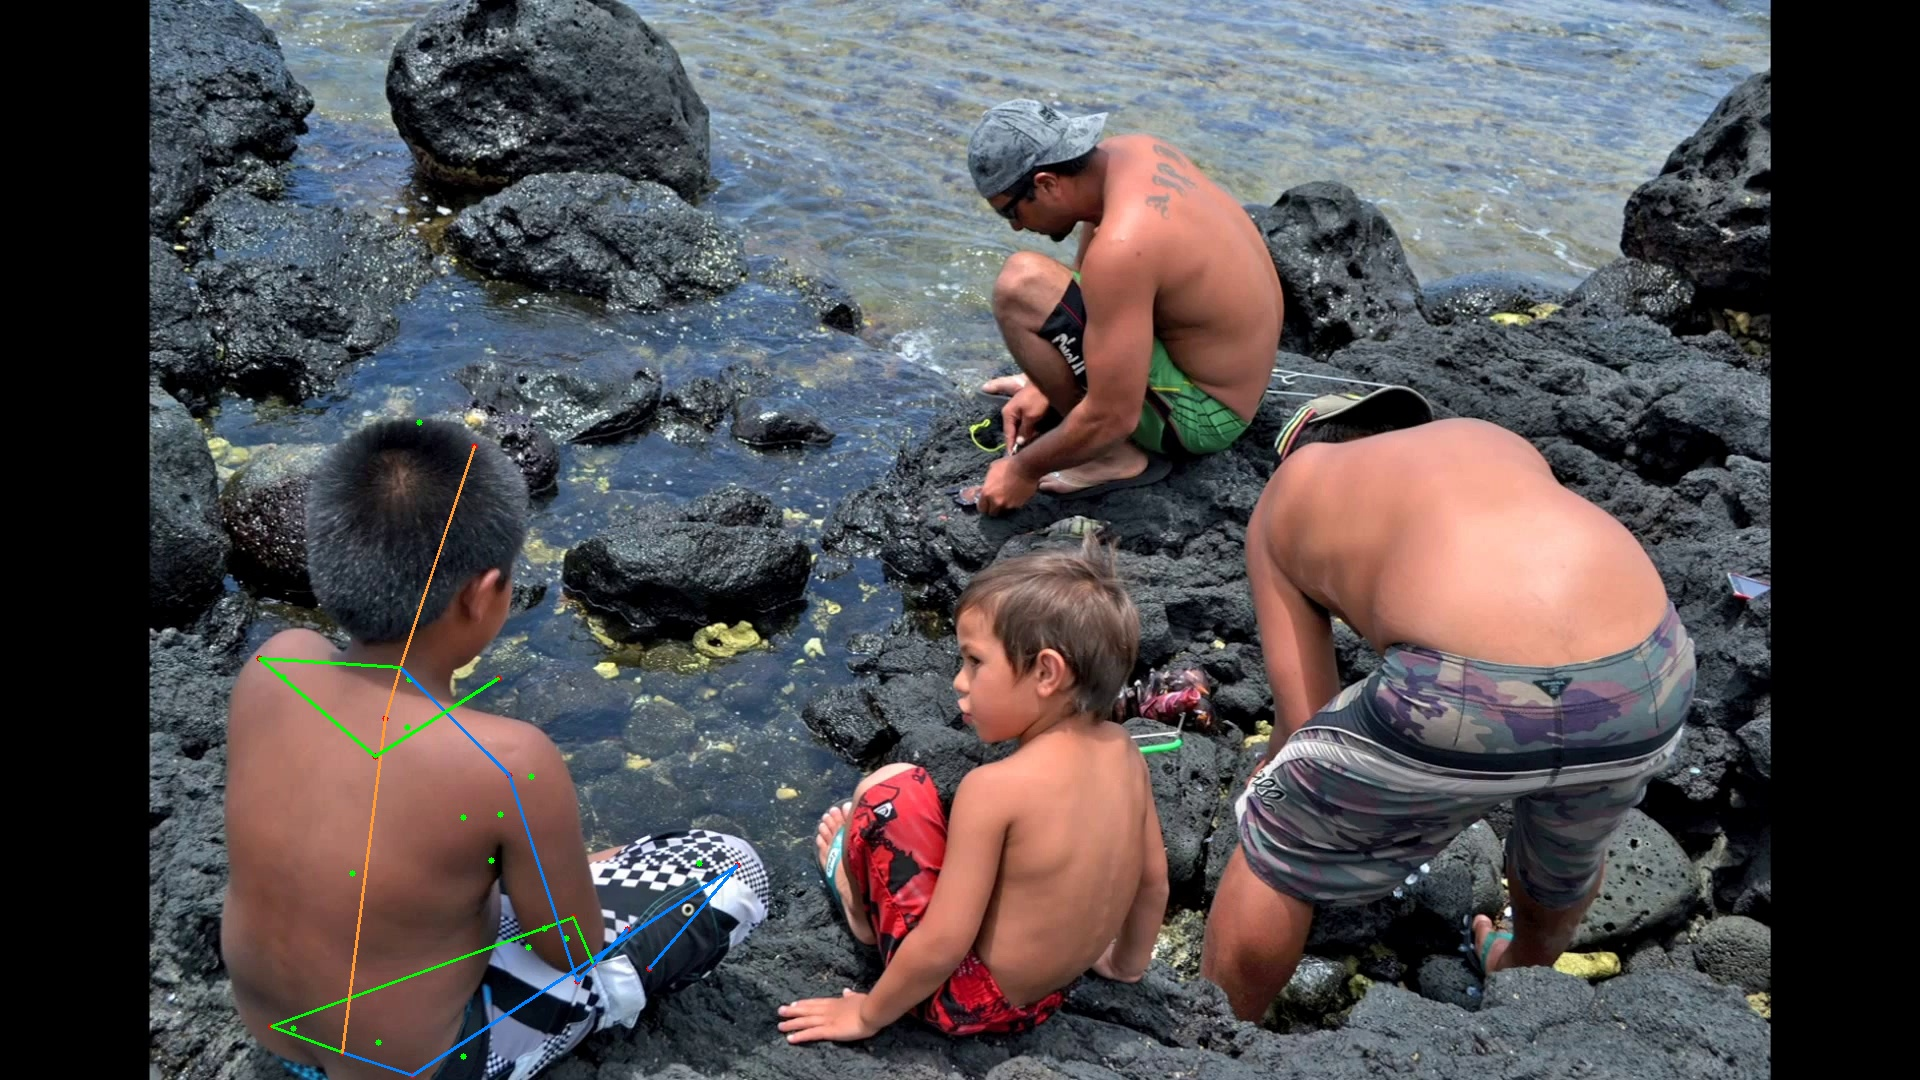

4007 000022704.jpg
[1416.0, 647.0]
2.020139
[[1445.0, 819.0], [1463.0, 729.0], [1480.0, 598.0], [-1.0, -1.0], [1443.0, 708.0], [1439.0, 813.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [1521.0, 533.0], [-1.0, -1.0], [1412.0, 457.0], [1382.0, 533.0], [1390.0, 600.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  0.0
(16, 2)
[[1445.0, 819.0], [1463.0, 729.0], [1480.0, 598.0], [-1.0, -1.0], [1443.0, 708.0], [1439.0, 813.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [1521.0, 533.0], [-1.0, -1.0], [1412.0, 457.0], [1382.0, 533.0], [1390.0, 600.0]]


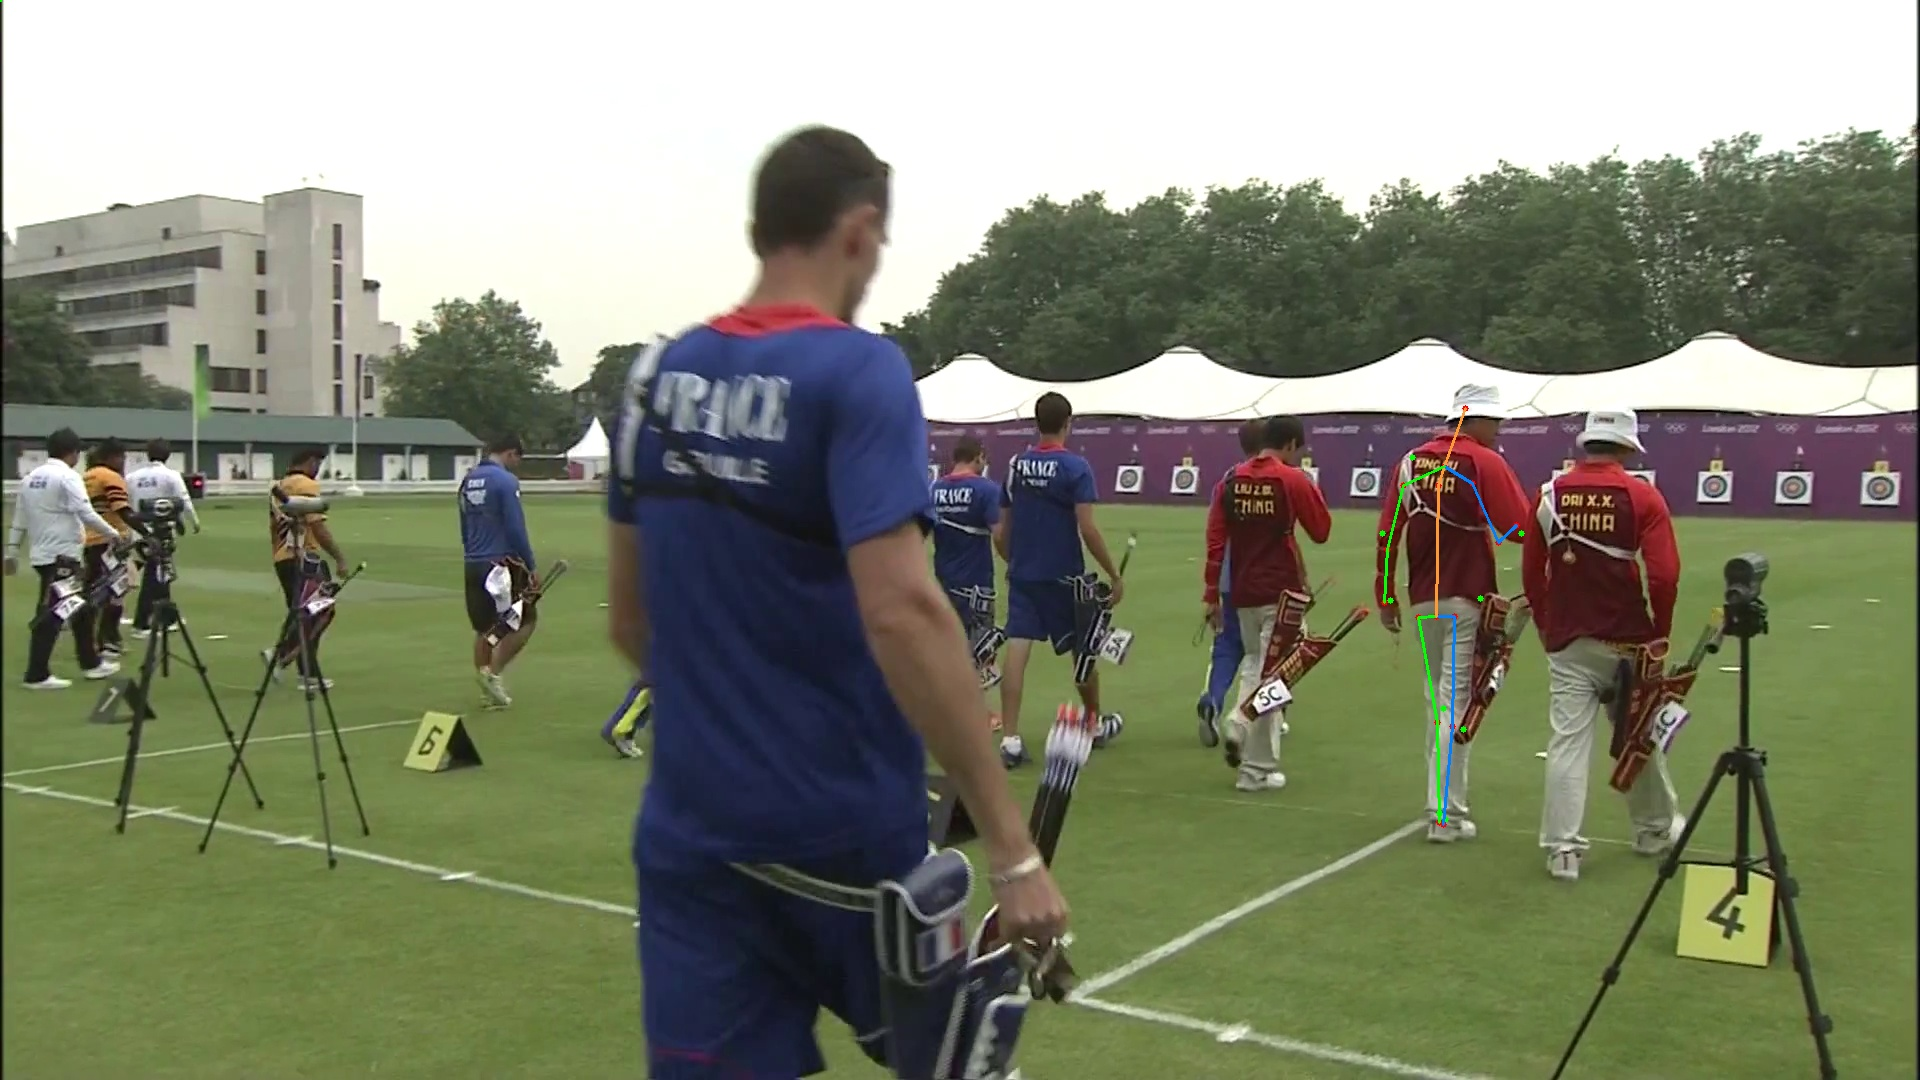

15165 050409511.jpg
[272.0, 230.0]
3.266999
[[298.0, 355.0], [240.0, 144.0], [38.0, 251.0], [102.0, 319.0], [291.0, 250.0], [262.0, 436.0], [70.0, 285.0], [249.0, 86.0], [255.2031, 82.16], [347.7969, 24.84], [508.0, 60.0], [379.0, 38.0], [217.0, 27.0], [280.0, 145.0], [379.0, 190.0], [487.0, 208.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  0.625
(16, 2)
[[298.0, 355.0], [240.0, 144.0], [38.0, 251.0], [102.0, 319.0], [291.0, 250.0], [262.0, 436.0], [70.0, 285.0], [249.0, 86.0], [255.2031, 82.16], [347.7969, 24.84], [508.0, 60.0], [379.0, 38.0], [217.0, 27.0], [280.0, 145.0], [379.0, 190.0], [487.0, 208.0]]


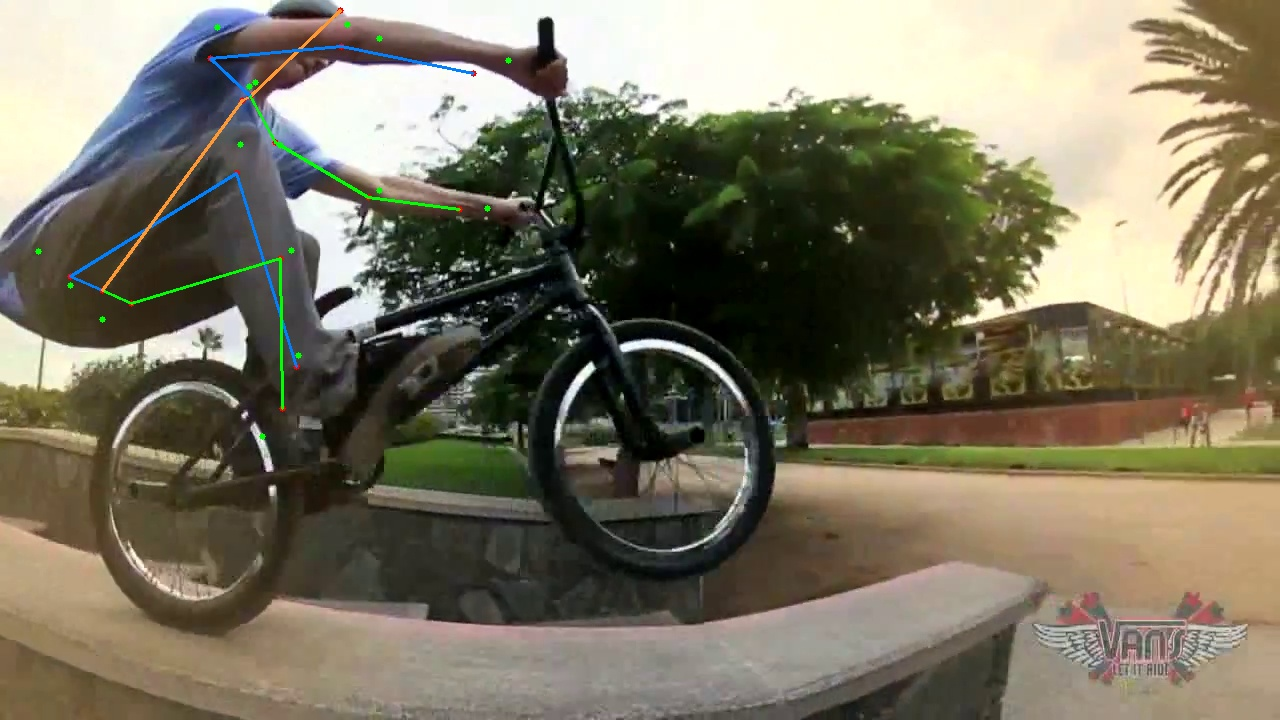

20683 006717543.jpg
[956.0, 500.0]
2.989903
[[-1.0, -1.0], [965.0, 572.0], [910.0, 593.0], [1032.0, 567.0], [1045.0, 657.0], [-1.0, -1.0], [971.0, 580.0], [940.0, 368.0], [953.9574, 378.3388], [1034.0426, 437.6612], [901.0, 554.0], [849.0, 516.0], [848.0, 381.0], [1032.0, 355.0], [1066.0, 487.0], [1039.0, 567.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  0.5
(16, 2)
[[-1.0, -1.0], [965.0, 572.0], [910.0, 593.0], [1032.0, 567.0], [1045.0, 657.0], [-1.0, -1.0], [971.0, 580.0], [940.0, 368.0], [953.9574, 378.3388], [1034.0426, 437.6612], [901.0, 554.0], [849.0, 516.0], [848.0, 381.0], [1032.0, 355.0], [1066.0, 487.0], [1039.0, 567.0]]


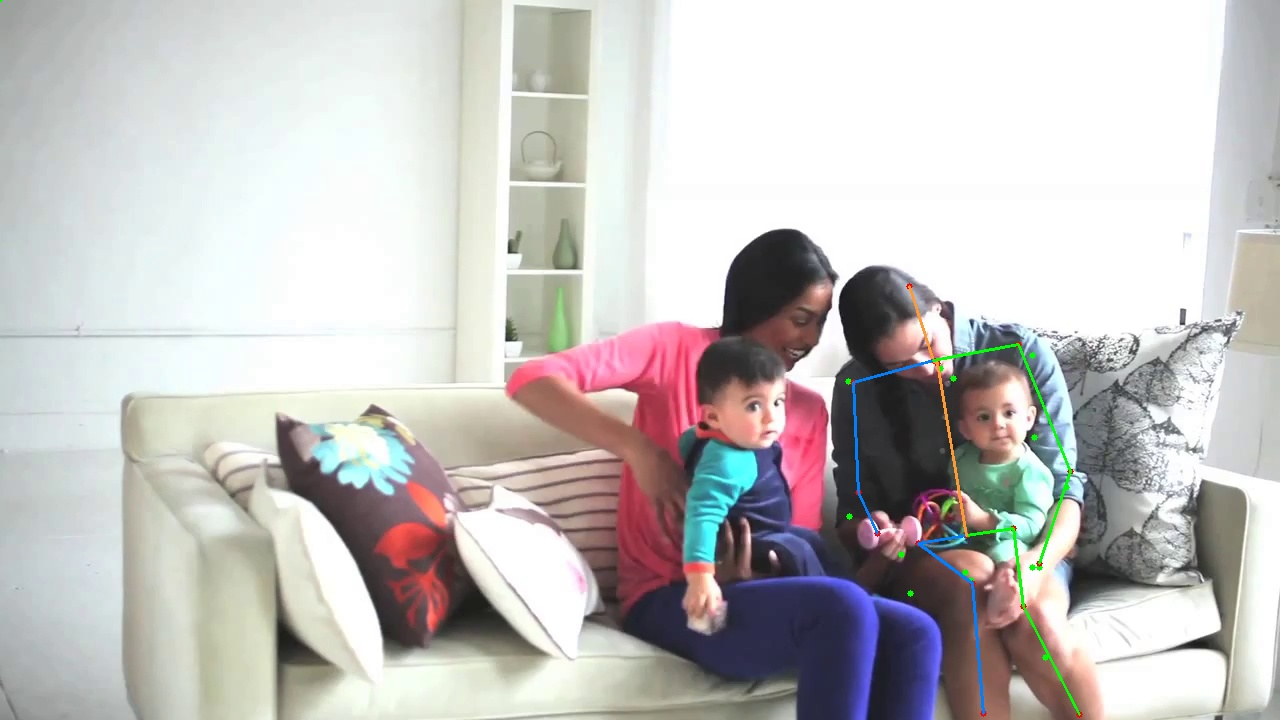

12484 068682122.jpg
[386.0, 855.0]
4.548617
[[-1.0, -1.0], [459.0, 911.0], [226.0, 803.0], [226.0, 803.0], [384.0, 855.0], [-1.0, -1.0], [226.0, 803.0], [469.0, 706.0], [498.8547, 702.0194], [649.1453, 681.9806], [443.0, 849.0], [324.0, 787.0], [461.0, 702.0], [477.0, 710.0], [410.0, 839.0], [306.0, 948.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  0.6875
(16, 2)
[[-1.0, -1.0], [459.0, 911.0], [226.0, 803.0], [226.0, 803.0], [384.0, 855.0], [-1.0, -1.0], [226.0, 803.0], [469.0, 706.0], [498.8547, 702.0194], [649.1453, 681.9806], [443.0, 849.0], [324.0, 787.0], [461.0, 702.0], [477.0, 710.0], [410.0, 839.0], [306.0, 948.0]]


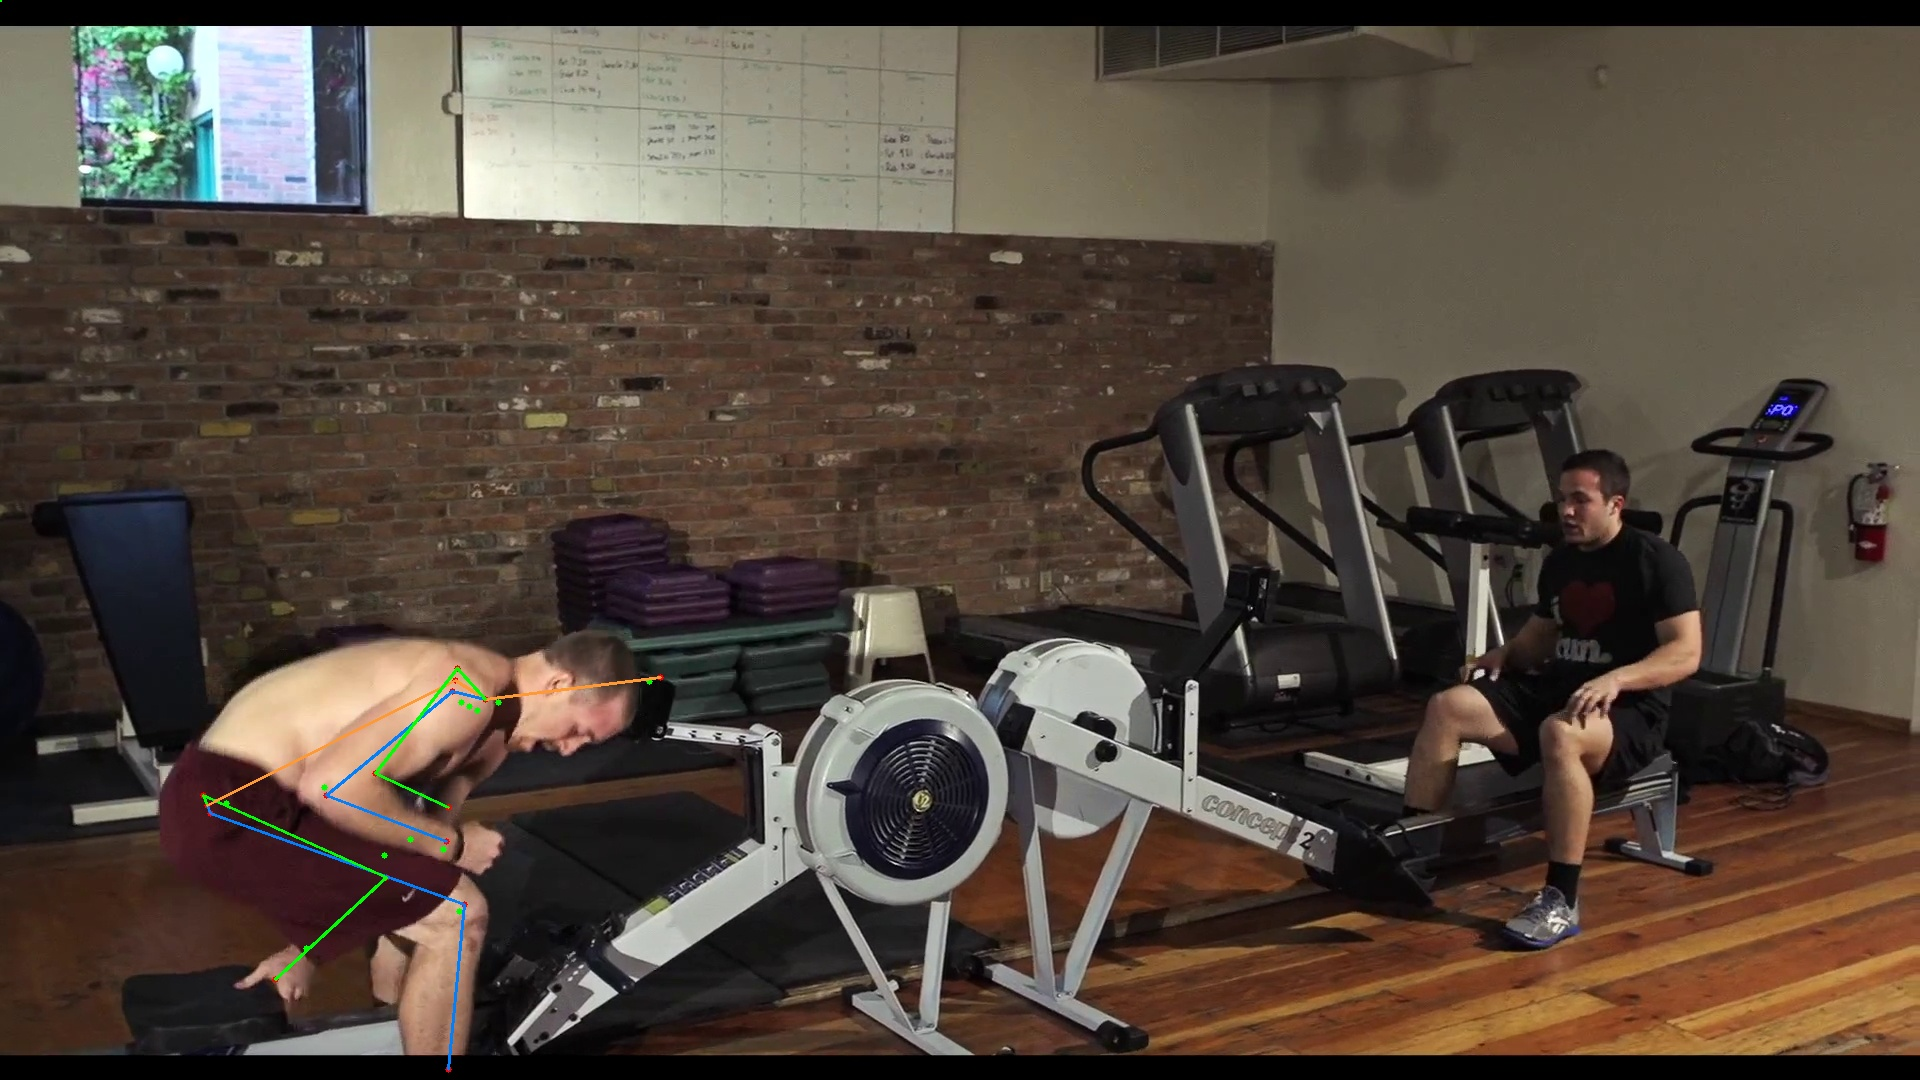

21513 056323331.jpg
[335.0, 499.0]
3.355626
[[315.0, 780.0], [294.0, 621.0], [312.0, 483.0], [366.0, 476.0], [338.0, 619.0], [427.0, 731.0], [339.0, 480.0], [331.0, 294.0], [324.423, 285.5783], [255.577, 197.4217], [266.0, 450.0], [284.0, 376.0], [291.0, 298.0], [371.0, 289.0], [408.0, 387.0], [378.0, 486.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  1.0
(16, 2)
[[315.0, 780.0], [294.0, 621.0], [312.0, 483.0], [366.0, 476.0], [338.0, 619.0], [427.0, 731.0], [339.0, 480.0], [331.0, 294.0], [324.423, 285.5783], [255.577, 197.4217], [266.0, 450.0], [284.0, 376.0], [291.0, 298.0], [371.0, 289.0], [408.0, 387.0], [378.0, 486.0]]


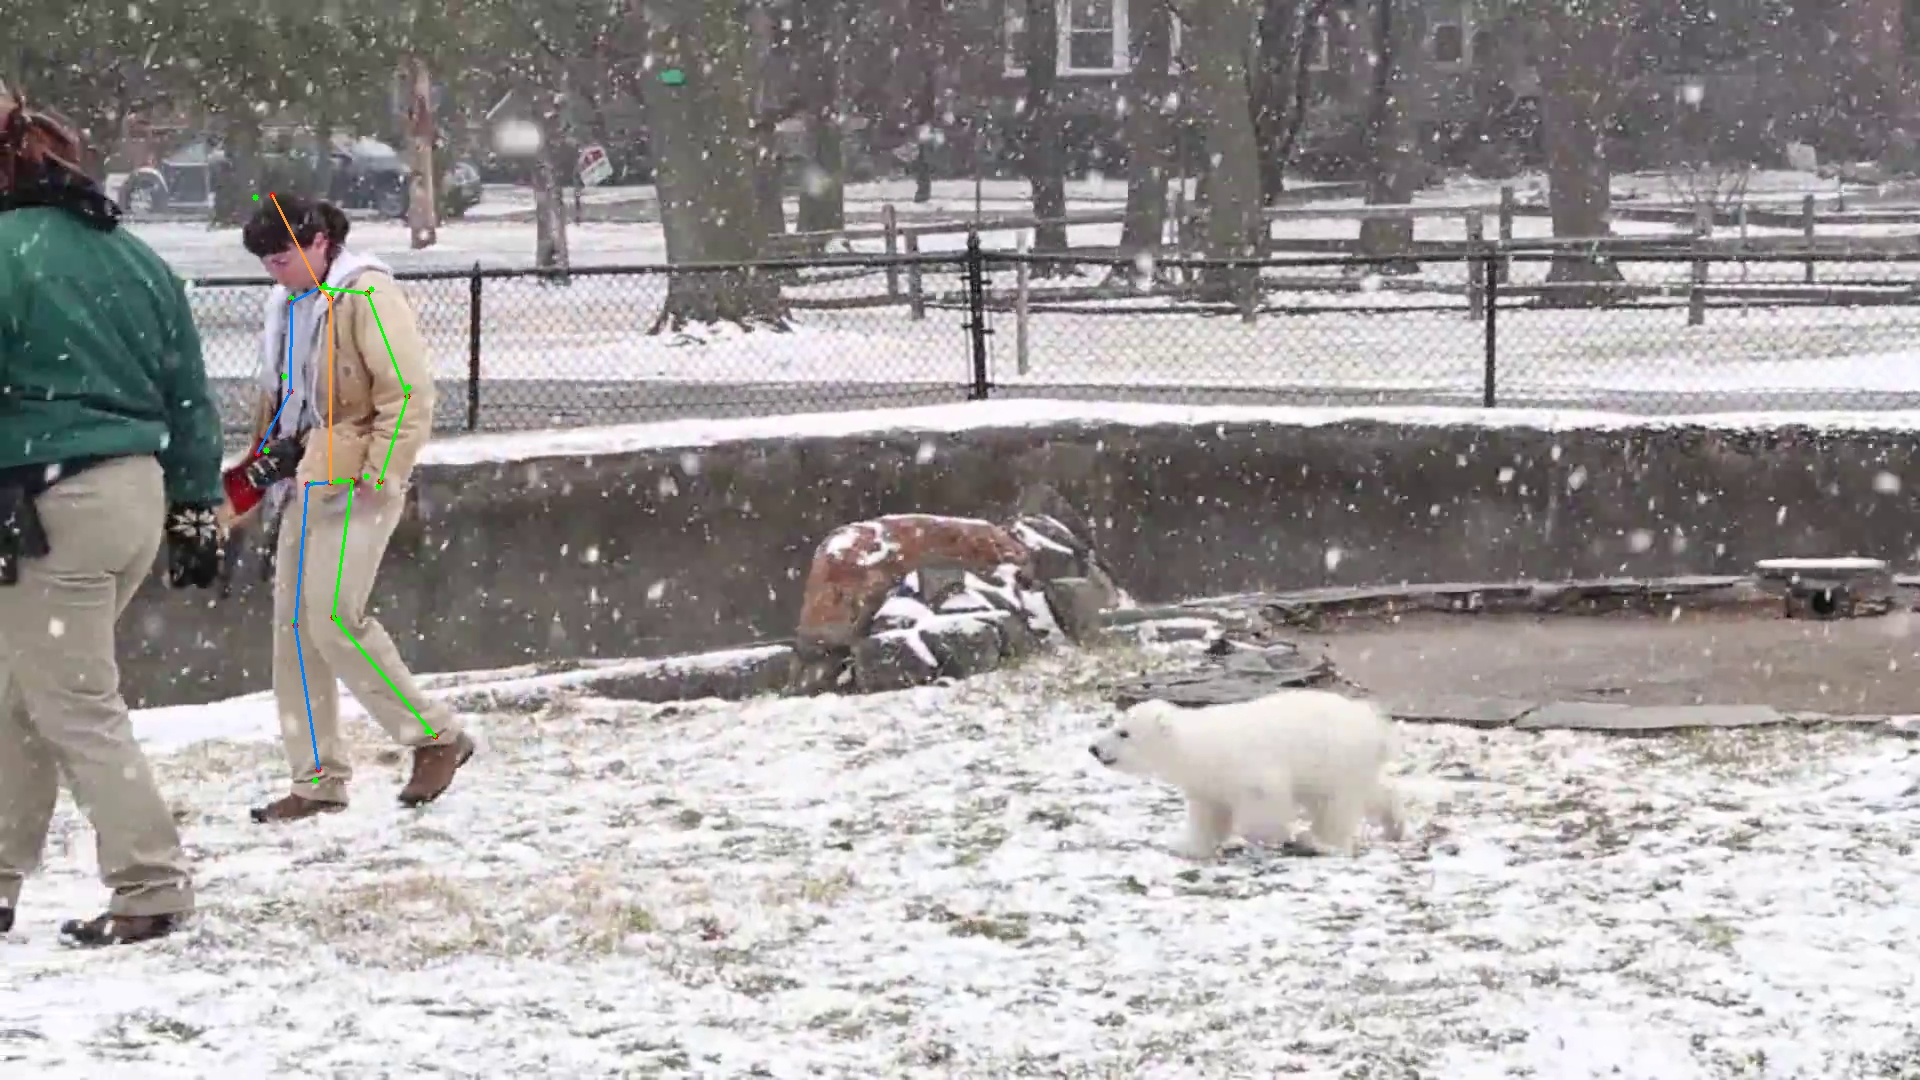

11462 041920001.jpg
[1048.0, 681.0]
10.081057
[[-1.0, -1.0], [-1.0, -1.0], [1294.0, 848.0], [1459.0, 885.0], [-1.0, -1.0], [-1.0, -1.0], [1377.0, 867.0], [1157.0, 457.0], [1077.1831, 429.2231], [759.8169, 318.7769], [994.0, 829.0], [1021.0, 631.0], [1077.0, 395.0], [1236.0, 519.0], [1338.0, 804.0], [1102.0, 876.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  0.75
(16, 2)
[[-1.0, -1.0], [-1.0, -1.0], [1294.0, 848.0], [1459.0, 885.0], [-1.0, -1.0], [-1.0, -1.0], [1377.0, 867.0], [1157.0, 457.0], [1077.1831, 429.2231], [759.8169, 318.7769], [994.0, 829.0], [1021.0, 631.0], [1077.0, 395.0], [1236.0, 519.0], [1338.0, 804.0], [1102.0, 876.0]]


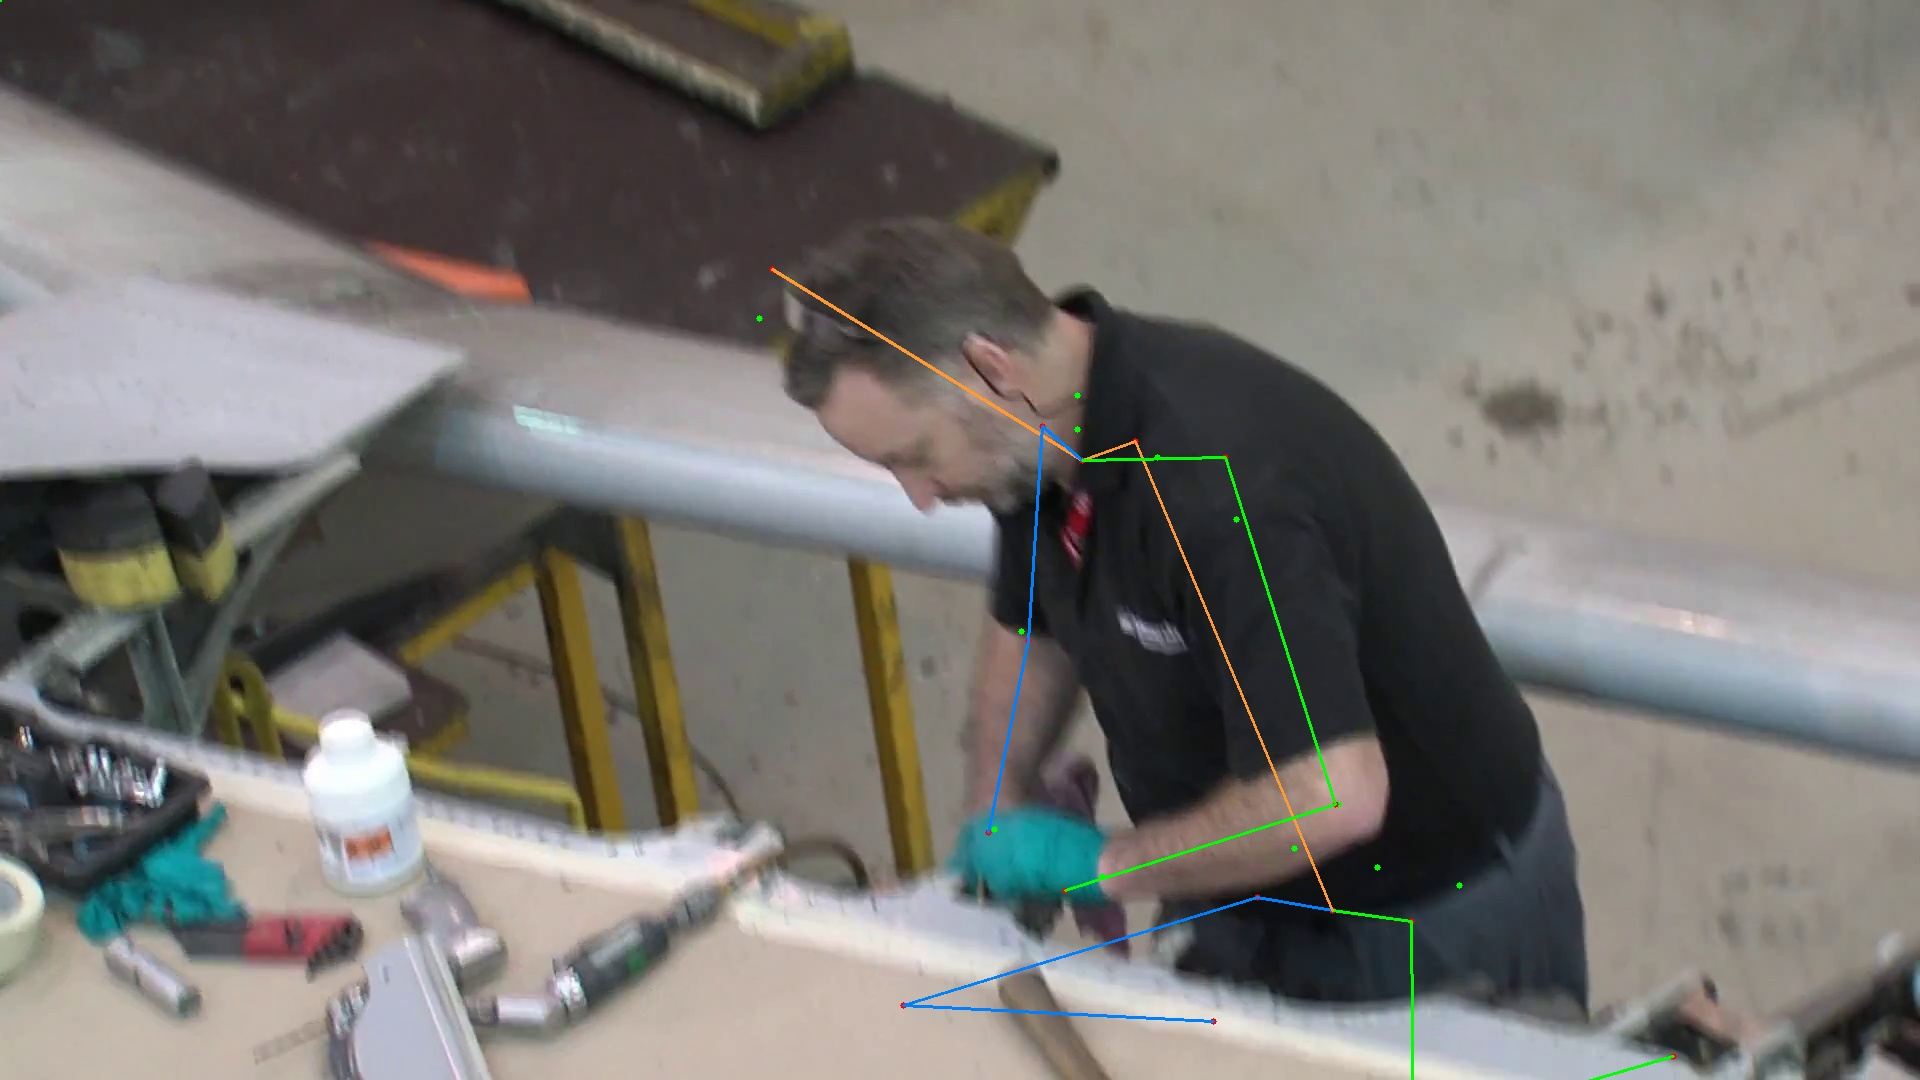

4133 004310011.jpg
[796.0, 384.0]
1.771616
[[824.0, 547.0], [830.0, 477.0], [770.0, 394.0], [786.0, 397.0], [816.0, 472.0], [781.0, 545.0], [778.0, 396.0], [755.0, 290.0], [756.3767, 280.2376], [764.6233, 221.7624], [768.0, 370.0], [753.0, 356.0], [738.0, 297.0], [772.0, 283.0], [784.0, 329.0], [802.0, 364.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  1.0
(16, 2)
[[824.0, 547.0], [830.0, 477.0], [770.0, 394.0], [786.0, 397.0], [816.0, 472.0], [781.0, 545.0], [778.0, 396.0], [755.0, 290.0], [756.3767, 280.2376], [764.6233, 221.7624], [768.0, 370.0], [753.0, 356.0], [738.0, 297.0], [772.0, 283.0], [784.0, 329.0], [802.0, 364.0]]


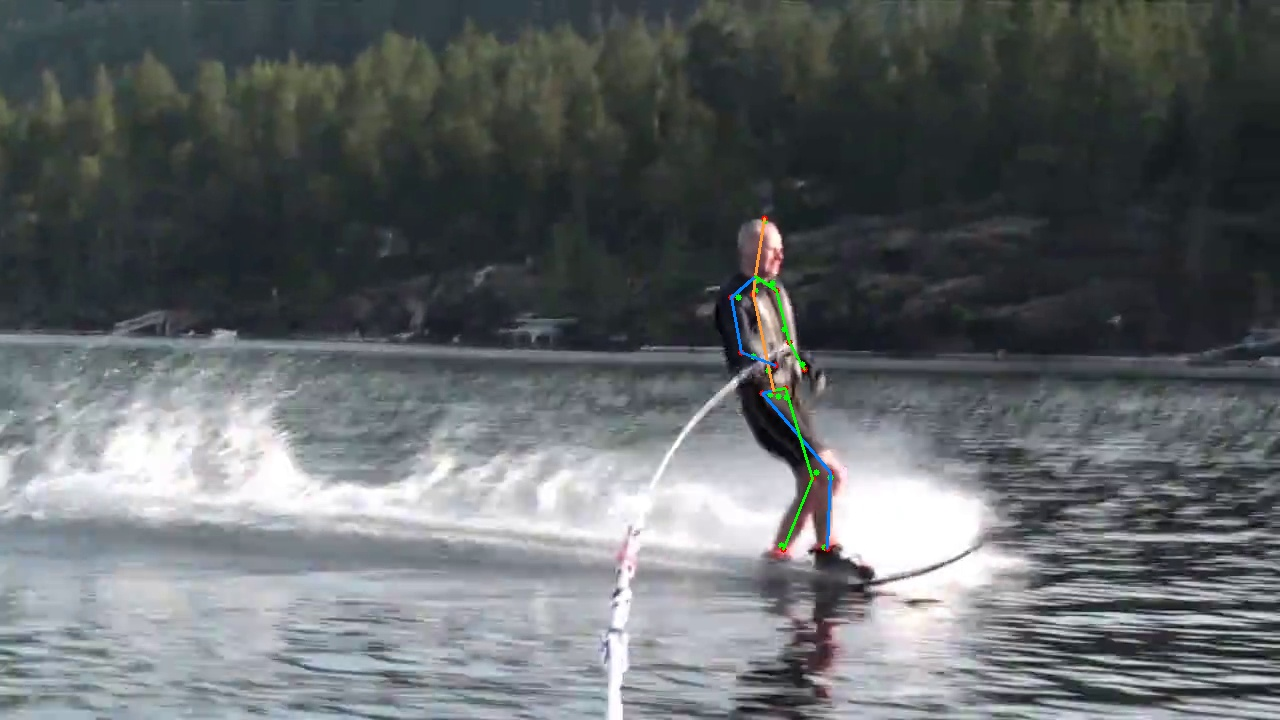

5923 084253451.jpg
[642.0, 411.0]
5.095805
[[-1.0, -1.0], [578.0, 663.0], [584.0, 483.0], [700.0, 475.0], [723.0, 663.0], [-1.0, -1.0], [642.0, 479.0], [631.0, 239.0], [633.8228, 223.9706], [665.1772, 57.0294], [584.0, 514.0], [501.0, 421.0], [514.0, 249.0], [747.0, 228.0], [776.0, 417.0], [764.0, 516.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  0.875
(16, 2)
[[-1.0, -1.0], [578.0, 663.0], [584.0, 483.0], [700.0, 475.0], [723.0, 663.0], [-1.0, -1.0], [642.0, 479.0], [631.0, 239.0], [633.8228, 223.9706], [665.1772, 57.0294], [584.0, 514.0], [501.0, 421.0], [514.0, 249.0], [747.0, 228.0], [776.0, 417.0], [764.0, 516.0]]


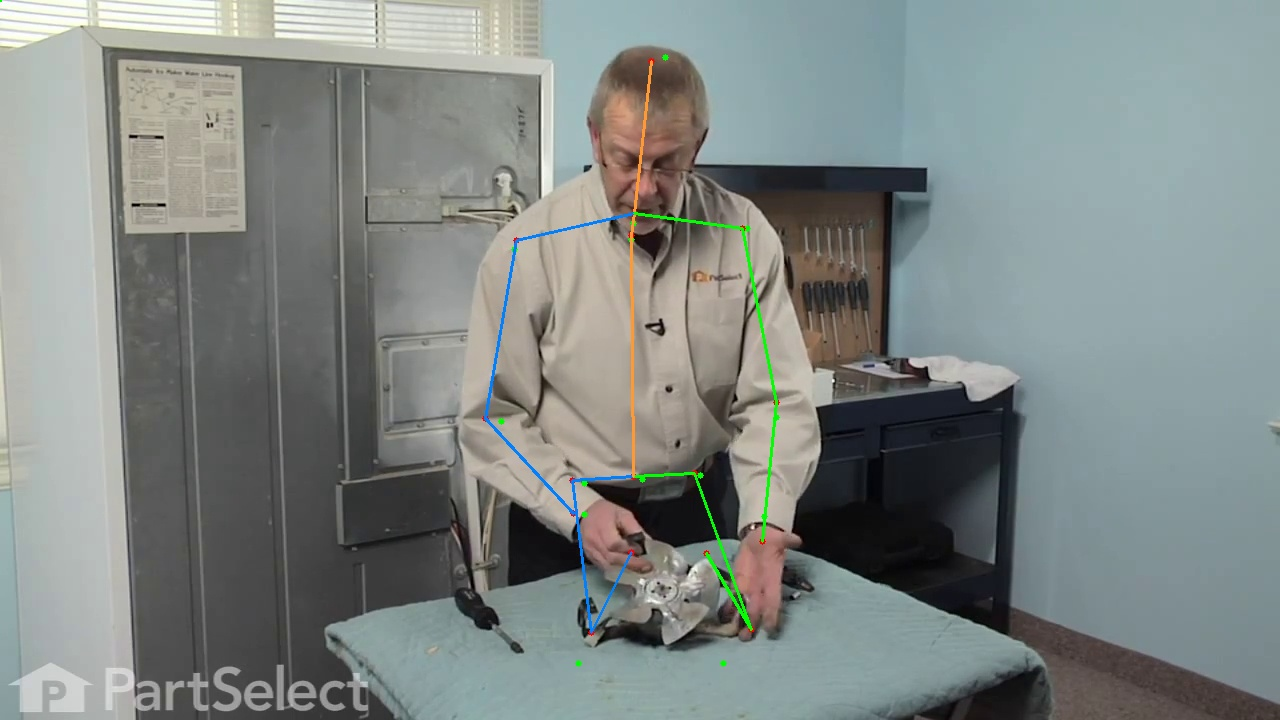

415 037625959.jpg
[586.0, 423.0]
4.001096
[[-1.0, -1.0], [573.0, 586.0], [583.0, 481.0], [662.0, 476.0], [693.0, 591.0], [-1.0, -1.0], [623.0, 479.0], [590.0, 259.0], [588.2405, 256.675], [507.7595, 150.325], [522.0, 449.0], [471.0, 365.0], [535.0, 274.0], [644.0, 243.0], [743.0, 331.0], [746.0, 426.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  0.6875
(16, 2)
[[-1.0, -1.0], [573.0, 586.0], [583.0, 481.0], [662.0, 476.0], [693.0, 591.0], [-1.0, -1.0], [623.0, 479.0], [590.0, 259.0], [588.2405, 256.675], [507.7595, 150.325], [522.0, 449.0], [471.0, 365.0], [535.0, 274.0], [644.0, 243.0], [743.0, 331.0], [746.0, 426.0]]


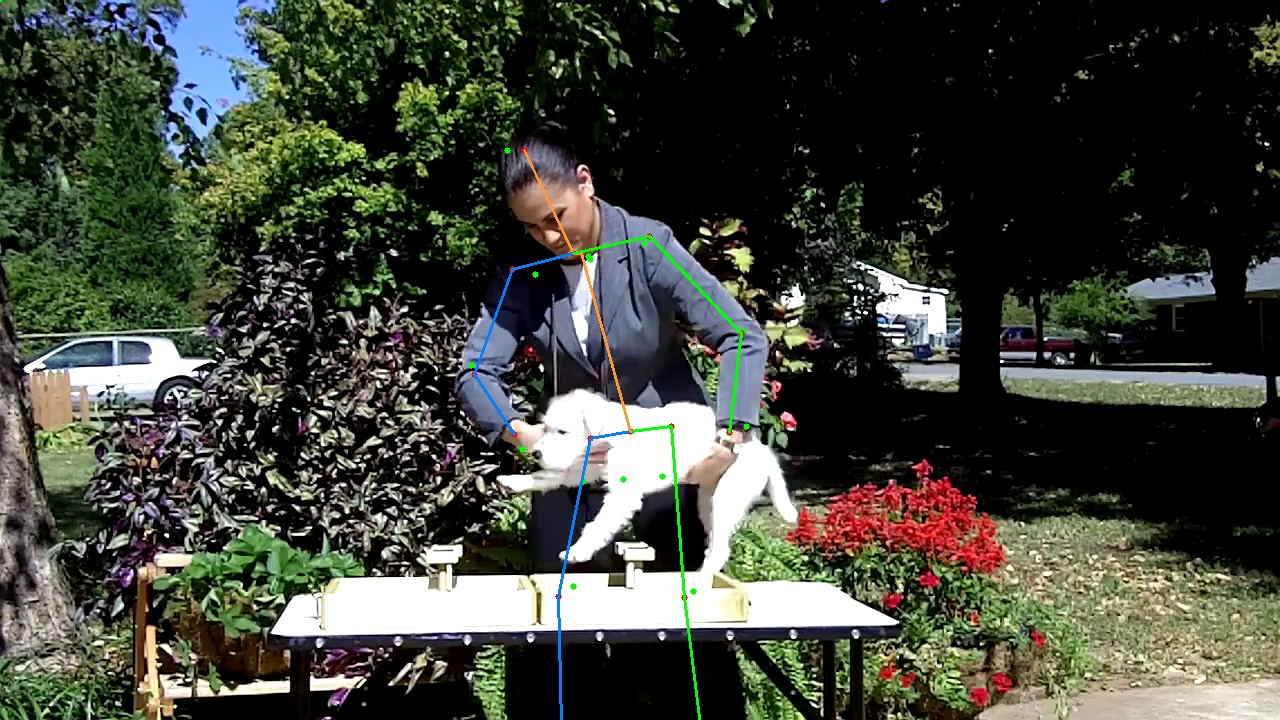

In [137]:

ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_train.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)


NUM_IMAGES = 10

# choose image from ground truth
def choose_n_images(gt_json):
  random_numbers = np.random.randint(0, len(gt_json), size=10)
  images = list()
  for nums in random_numbers:
     images.append((nums,gt_json[nums]['image']))
  return images

for index, im_path in choose_n_images(annot_truth):
  print(index, im_path)
  # Load the image
  image = cv2.imread(ROOT_FOLDER + '/data/MPII_COCO/images/' + im_path)

  # Load annotation keypoints from JSON files

  keypoints1 = annot_truth[index]['joints']
  # pred
  print(annot_truth[index]['center'])
  print(annot_truth[index]['scale'])
  print(keypoints1)

  points = np.array(annot_pred_coco['annotations'][index]['joints'])
  points = (points - np.array(annot_truth[index]['center'])) / annot_truth[index]['scale']
  points = standardize(points)
  print(points.shape)
  points = torch.tensor(points, dtype=torch.float32)
  points = points.unsqueeze(0)
  keypoints2 = None
  print(points.shape)
  best_model.eval()
  with torch.no_grad():
    points = points.to(device)
    keypoints2 = best_model(points)


  keypoints2 = keypoints2.squeeze()
  # print(np.array(annot_truth[index]['joints']))
  keypoints2 = keypoints2.to('cpu')
  keypoints2 = np.array(keypoints2)
  keypoints2 = unstandardize(keypoints2)

  keypoints2 = annot_truth[index]['scale'] * keypoints2
  keypoints2 = keypoints2 + np.array(annot_truth[index]['center'])

  print("PCKh: ", calculatePCKh(torch.tensor(keypoints2, dtype=torch.float32).unsqueeze(0),
                                torch.tensor(annot_truth[index]['joints'], dtype=torch.float32).unsqueeze(0) ))

  print(keypoints2.shape)
  # Draw keypoints on the image
  for kp in keypoints1:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  for kp in keypoints2:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 0, 255), -1)

  print(keypoints1)
  for id,val in dataset_info['skeleton_info'].items():
      # if int(keypoints1[kps_name2index[val['link'][0]]][0])  == -1:
      #   continue
      # if int(keypoints1[kps_name2index[val['link'][1]]][0])  == -1:
      #   continue
      start_point = (int(keypoints2[kps_name2index[val['link'][0]]][0] )), int(keypoints2[kps_name2index[val['link'][0]]][1])
      end_point = (int(keypoints2[kps_name2index[val['link'][1]]][0] )), int(keypoints2[kps_name2index[val['link'][1]]][1])
      cv2.line(image, start_point, end_point, val['color'], 2)  # Yellow color for lines
  # Resize the image if necessary
  # This step is optional, depending on your images

  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'tm_results/image{index}.jpg', image)

  display(Image(filename=f'tm_results/image{index}.jpg'))


# Try building simple regressors

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])
print("Test instance: ", X_test.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


Train instance:  7861
Val instance:  2621
Test instance:  4493
torch.Size([7861, 17, 2])
torch.Size([7861, 16, 2])
torch.Size([2621, 17, 2])
torch.Size([2621, 16, 2])


In [ ]:
from sklearn import linear_model

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_train_stacked = np.reshape(X_train, (X_train.shape[0], -1))
print(X_train_stacked.shape)
X_val_stacked = np.reshape(X_val, (X_val.shape[0], -1))
print(X_val_stacked.shape)
print('y_val: ', y_val.shape)

for point in range(16):
  y_train_point = y_train[:, point]
  clf_x = linear_model.LinearRegression()
  clf_y = linear_model.LinearRegression()

  clf_x.fit(X_train_stacked, y_train_point[:, 0])
  clf_y.fit(X_train_stacked, y_train_point[:, 1])

  prediction_x = clf_x.predict(X_val_stacked)
  prediction_y = clf_y.predict(X_val_stacked)

  pred = np.stack((prediction_x, prediction_y), axis=1)
  error = ((pred - y_val[:, point]) ** 2).mean(axis = 1)
  # print(error[:10])
  error = np.mean(error)
  print(f'Error {point}: {error}')

    

(7861, 34)
(2621, 34)
y_val:  (2621, 16, 2)
Error 0: 224.21932983398438
Error 1: 94.02581024169922
Error 2: 57.048316955566406
Error 3: 58.99836730957031
Error 4: 89.52011108398438
Error 5: 235.37953186035156
Error 6: 46.26677322387695
Error 7: 25.42369842529297
Error 8: 27.508214950561523
Error 9: 55.37346267700195
Error 10: 188.04627990722656
Error 11: 76.92213439941406
Error 12: 42.63243103027344
Error 13: 43.588462829589844
Error 14: 81.3226089477539
Error 15: 133.448974609375


In [ ]:
X_val = np.array(X_val)
y_val = np.array(y_val)
print(X_val.shape)
print(y_val.shape)

(2621, 17, 2)
(2621, 16, 2)


In [ ]:
print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))
print((abs(X_val[:, 14] - y_val[:, 1])).mean(axis=0))
# Around head location
print((abs(X_val[:, 0] - y_val[:, 9])).mean(axis=0))

# print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))
# print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))
# print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))


[5.7771764 6.6435676]
[4.1824436 5.1991277]
[ 6.9651403 18.852098 ]
